# Disease Spread

With the outbreak of the *coronavirus* (COVID-19) in late 2019 and early 2020 there has been an increased interest in modeling the impacts of epidemic and pandemic. Live organisms, and particularly human beings, interact in cmplex ways and are highly dynamic, so trying to capture every movement, every surface touched, every contact between two or more individuals for every human being seems impossible. 

However, with the increasing number of georeferenced information about our commuting patterns, traffic congestions, maps of roads and subways, population demographics, improved weather observation and forecasts, and overall knowledge about human activity simulations are becoming increasingly more detailed.

Incorporating these and many more variables, even for a small country, could take substantil computing power and an interdisciplinary group of scientists. In this exercise we will implement a simplistic simulation to analyze the impact of few paramters on the spread of a made-up disease within an arbitrary small population. We will take into account social distancing and rate at which individuals move. The goal is to learn how to implement simple interactions.

The code below is by no means intended for research use, but it may serve as the basis for creating simple models with few individuals or animals, perhaps something like the spread of a disease within animals in a pasture.


## Ground rules and coding decisions

- The model assumes an established population with no birth rate.

- The model does not considered the effect of race, age, sex, or physical condition of the individuals.

- At the quarentine day mark, all infected people that did not die automatically recover.

- Recovered individuals become immune to the disease and do not become infected again.

- Recovered individuals no longer transmit the disease to normal individuals.

- When individuals reach the boundary of the system they automatically show up on the opposite side. This called a *torus* (or periodic) boundary condition and approximates an infinite system.


## Inspiration

The code implemented in this notebook was inspired by an article published in the Washington post about a made-up illness called simulities written by Harry Stevens (see references for more details). The code is not an exact replica of the simulation in the article by Stevens, but my own interpretation, where I aimed for simplicity so that new coders with some handle of Python can understand the flow of the code.


In [2]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Remove warnings to prevent message when doing boolean statements with NaNs
# Enable at the end, but avoid during the early prototyping stages
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)


In [3]:
# Define function to compute euclidean distance between individuals
def edist(x,y):
    df = np.kron(np.ones(N),[x,y]) - np.kron([x,y],np.ones(N)) # Compute differences using Kronecker product
    E = np.sqrt(df[0]**2 + df[1]**2) # Compute Euclidean distance.
    E = np.reshape(E,[N,N])
    return E


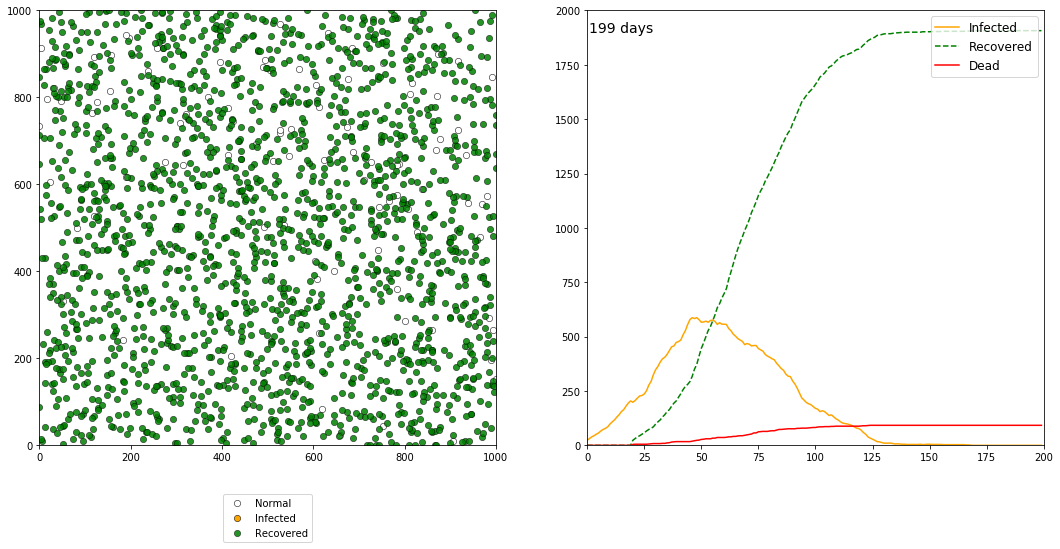

In [25]:
# Set random seed for reproducibility
np.random.seed(1)

# Simulation space constraints
xmin = 0       # Left system boundary
xmax = 1000    # Right system boundary
ymin = 0       # Lower system boundary
ymax = 1000    # Upper system boundary

# Simulation time constraints
simulation_length = 200 # Number of simulation days
simulation_time = np.array([0])

# Existing population
N = 2000 # Number of live individuals
live = np.ones(N, dtype=bool)
dead = np.zeros(N, dtype=bool)

# Initial health conditions
normal = np.ones(N, dtype=bool)
infected = np.zeros(N, dtype=bool)
recovered = np.zeros(N, dtype=bool)

# Initial positions and directions of live individuals
x = np.random.uniform(xmin,xmax,N)
y = np.random.uniform(ymin,ymax,N)
theta = np.radians(np.random.uniform(0,360,N)) # Angle of movement
speed = xmax/100 # rate at which individuals move.
speed_active = np.ones(N) * speed # speed for every individual active

# Social distancing
# Distance below which one infected individual can transmit the
# disease to a normal (healthy) individual
social_distance = 15   # Arbitrary distance
start_stay_home_order = 50  # number of days
end_stay_home_order = 100   # number of days
fraction_static = 0.7  # Change this to keep people static (at home)
static_individuals = np.random.randint(low=0, high=N, size=round(N*fraction_static))

# Death rate 
death_rate = 5/100

# Initialize quanrentine time for infected individuals
quarentine_period = 21
quarentine_time = np.zeros(N)

# Inoculate a small group of individuals
#N_seed = 10   # Individuals infected at the epicenter
#infected_seeds = np.random.randint(low=0, high=N, size=N_seed)  # Random seeds
infected_seeds = np.sqrt((x-xmax/2)**2 + (y-ymax/2)**2) < 50    # Center seeds
infected[infected_seeds] = True
normal[infected_seeds] = False

# Initialize totals
total_live = live.sum()
total_dead = dead.sum()
total_normal = normal.sum()
total_infected = infected.sum()
total_recovered = recovered.sum()

# Start recursive iteration
for t in range(simulation_length):
   
    # Track time
    simulation_time = np.append(simulation_time, t)
    
    # Implement/remove social distancing when time equals start/end stay-home order
    if t == start_stay_home_order:
        speed_active[static_individuals] = 0
        
    elif t == end_stay_home_order:
        speed_active[static_individuals] = speed

    # Compute next positions of individuals
    x = x + speed_active * np.cos(theta)
    y = y + speed_active * np.sin(theta)
    
    # Implement torus boundaries.
    x[x < xmin] = xmax
    x[x > xmax] = xmin
    y[y < ymin] = ymax
    y[y > ymax] = ymin
    
    # Determine whether two individuals come in contact
    E = edist(x,y)
    E[np.eye(N, dtype='bool')] = np.inf # selfs set to inf to prevent selecting in next step
    rows,cols = np.where(E <= social_distance)
    
    # New infected live individuals
    idx_infected = infected[rows] | infected[cols] & ~recovered[rows]
    infected[rows[idx_infected]] = True
    normal[rows[idx_infected]] = False

    # Change trajectory angle if hit another individual
    theta[rows] = np.abs(np.degrees(np.radians(theta[rows]+90))- 360) 

    # Update quarentine time for infected individuals
    quarentine_time[infected] += 1
        
    # Remove dead individuals from population
    idx_potential_dead = infected & (quarentine_time == quarentine_period)
    daily_probability_dead = np.random.rand(N)
    daily_probability_dead[~idx_potential_dead] = 0
    idx_dead = daily_probability_dead >= (1-death_rate)
    dead[idx_dead] = True
    live[idx_dead] = False
    infected[idx_dead] = False
    recovered[idx_dead] = False
    normal[idx_dead] = False
    
    # Recovery of infected individuals that reached quarentine
    idx_recovered = quarentine_time == quarentine_period
    quarentine_time[idx_recovered] = 0
    recovered[idx_recovered] = True
    normal[idx_recovered] = False
    infected[idx_recovered] = False

    # Convert positions of dead individuals to NaN
    #quarentine_time[idx_recovered] = np.nan
    x[idx_dead] = np.nan
    y[idx_dead] = np.nan
    theta[idx_dead] = np.nan
    
    # Compute totals
    total_live = np.append(total_live, live.sum())
    total_dead = np.append(total_dead, dead.sum())
    total_normal = np.append(total_normal, normal.sum())
    total_infected = np.append(total_infected, infected.sum())
    total_recovered = np.append(total_recovered, recovered.sum())
    
    # Plot chart with current positions and health
    plt.figure(figsize=(18,8))
    clear_output(wait=True)
    plt.subplot(1,2,1)
    plt.scatter(x[normal],y[normal],s=40, marker='o',facecolor='w',edgecolor='k', linewidth=0.5, label='Normal')
    plt.scatter(x[infected],y[infected],s=40,marker='o',facecolor='orange',edgecolor='k',linewidth=0.5,label='Infected')
    plt.scatter(x[recovered],y[recovered],s=40,marker='o',facecolor='green',edgecolor='k',linewidth=0.5, alpha=0.85, label='Recovered')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1))
    
    # Set limits of the plot
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    
    # Plot progression of health condition
    plt.subplot(1,2,2)
    plt.plot(simulation_time,total_infected, linestyle='-', color='orange',label='Infected')
    plt.plot(simulation_time,total_recovered, '--g',label='Recovered')
    plt.plot(simulation_time,total_dead, '-r',label='Dead')
    plt.xlim(0,simulation_length)
    plt.ylim(0,N)
    plt.legend(loc='upper right', fontsize=12)
    plt.annotate(str(t) + " days", xy=(1,N-N*0.05), size=14)
    plt.show()
    

## References

"Why outbreaks like coronavirus spread exponentially, and how to flatten the curve" by Harry Stevens. Published on March 14, 2020 by the Washington Post. [Full story](https://www.washingtonpost.com/graphics/2020/world/corona-simulator/).